In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
from particles import resampling as rs
import sys
sys.path.append('..')

import GaussianODEs as ode

In [2]:
mu = 20
sigma = 1
mu0 = 0
sigma0 = 100

In [3]:
gamma = 0.01
discr = 15

Exact WFR
$$
 m_t = m_\pi + (m_0 - m_\pi) \exp \left( \frac{t}{C_\pi} \right) \frac{C_t - C_\pi}{C_0 - C_\pi} 
$$
$$
C_t = C_\pi + \left( \left(\frac{1}{C_0 - C_\pi} + \frac{1}{C_\pi + 2}\right) e^{\left(1 + \frac{2}{C_\pi}\right)t} - \frac{1}{C_\pi + 2} \right)^{-1}$$

For the sequential splitting scheme we have that, 
\begin{align*}
    \tilde{m}_1 &= e^{-t C_\pi^{-1} }m_0 + (I - e^{- t C_\pi^{-1} })m_\pi \\
    \tilde{C}_1 &= e^{-2 t C_\pi^{-1}}[C_0 + C_\pi(e^{2 t C_\pi^{-1}} - 1)]
\end{align*}
is the mean and covariance after one step of W process and 
\begin{align}
    C_1^{-1} &= C_\pi^{-1}+e^{-t}(\tilde{C}_1^{-1}-C_\pi^{-1}) \\
m_1 &= m_\pi + e^{-t}C_1 \tilde{C}_1^{-1}(\tilde{m}_1 - m_\pi) 
\end{align}
is the mean and covariance after a subsequent step of FR process, i.e. the sequential split solution to the WFR flow after one step of size $t$.  

In [4]:
def exact_wfr(mu, sigma, mu0, sigma0, t):
    C = sigma+((1/(sigma0-sigma)+1/(sigma+2))*np.exp(t*(1+2/sigma)) - 1/(sigma+2))**(-1)
    m = mu+(mu0-mu)*np.exp(t/sigma)*(C-sigma)/(sigma0-sigma)
    return m, C
def exact_fr(mu, sigma, mu0, sigma0, t):
    C = (1/sigma + np.exp(-t)*(1/sigma0-1/sigma))**(-1)
    m = mu + np.exp(-t)*C*(mu0-mu)/sigma0
    return m, C
def exact_w(mu, sigma, mu0, sigma0, t):
    C = np.exp(-2*t/sigma)*(sigma0+sigma*(np.exp(2*t/sigma)-1))
    m = np.exp(-t/sigma)*mu0 + mu*(1-np.exp(-t/sigma))
    return m, C

## WFR

In [5]:
mean_eq_wfr = np.zeros(discr)
var_eq_wfr = np.zeros(discr)
kl_evo_wfr = np.zeros(discr)

mean_eq_seq_wfr = np.zeros(discr)
var_eq_seq_wfr = np.zeros(discr)
kl_evo_seq_wfr = np.zeros(discr)

mean_eq_strang_wfr = np.zeros(discr)
var_eq_strang_wfr = np.zeros(discr)
kl_evo_strang_wfr = np.zeros(discr)

for i in range(discr):
    mean_eq_wfr[i], var_eq_wfr[i] = exact_wfr(mu, sigma, mu0, sigma0, gamma*i)
    kl_evo_wfr[i] = ode.KL(mean_eq_wfr[i], var_eq_wfr[i], mu, sigma)
    tmp_mean, tmp_var = exact_w(mu, sigma, mu0, sigma0, gamma*i)
    mean_eq_seq_wfr[i], var_eq_seq_wfr[i] = exact_fr(mu, sigma, tmp_mean, tmp_var, gamma*i)
    kl_evo_seq_wfr[i] = ode.KL(mean_eq_seq_wfr[i], var_eq_seq_wfr[i], mu, sigma)
    tmp_mean, tmp_var = exact_w(mu, sigma, mu0, sigma0, 0.5*gamma*i)
    tmp_mean2, tmp_var2 = exact_fr(mu, sigma, tmp_mean, tmp_var, gamma*i)
    mean_eq_strang_wfr[i], var_eq_strang_wfr[i] = exact_w(mu, sigma, tmp_mean2, tmp_var2, 0.5*gamma*i)
    kl_evo_strang_wfr[i] = ode.KL(mean_eq_strang_wfr[i], var_eq_strang_wfr[i], mu, sigma)

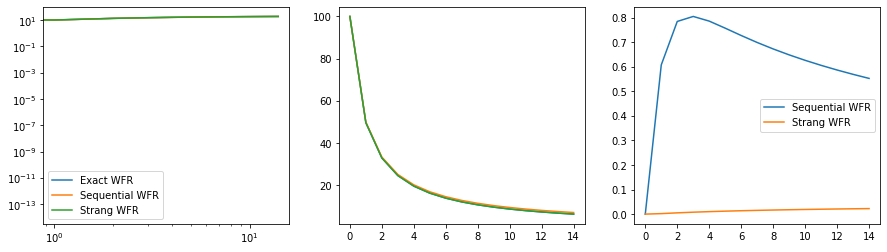

In [6]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1)
plt.loglog(mean_eq_wfr, label = 'Exact WFR')
plt.plot(mean_eq_seq_wfr, label = 'Sequential WFR')
plt.plot(mean_eq_strang_wfr, label = 'Strang WFR')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(var_eq_wfr, label = 'Exact WFR')
plt.plot(var_eq_seq_wfr, label = 'Sequential WFR')
plt.plot(var_eq_strang_wfr, label = 'Strang WFR')
plt.subplot(1, 3, 3)
plt.plot(kl_evo_seq_wfr - kl_evo_wfr, label = 'Sequential WFR')
plt.plot(kl_evo_strang_wfr - kl_evo_wfr, label = 'Strang WFR')
plt.legend()

## FRW

In [7]:
mean_eq_wfr = np.zeros(discr)
var_eq_wfr = np.zeros(discr)
kl_evo_wfr = np.zeros(discr)

mean_eq_seq_frw = np.zeros(discr)
var_eq_seq_frw = np.zeros(discr)
kl_evo_seq_frw = np.zeros(discr)

mean_eq_strang_frw = np.zeros(discr)
var_eq_strang_frw = np.zeros(discr)
kl_evo_strang_frw = np.zeros(discr)

for i in range(discr):
    mean_eq_wfr[i], var_eq_wfr[i] = exact_wfr(mu, sigma, mu0, sigma0, gamma*i)
    kl_evo_wfr[i] = ode.KL(mean_eq_wfr[i], var_eq_wfr[i], mu, sigma)    
    tmp_mean, tmp_var = exact_fr(mu, sigma, mu0, sigma0, gamma*i)
    mean_eq_seq_frw[i], var_eq_seq_frw[i] = exact_w(mu, sigma, tmp_mean, tmp_var, gamma*i)
    kl_evo_seq_frw[i] = ode.KL(mean_eq_seq_frw[i], var_eq_seq_frw[i], mu, sigma)
    tmp_mean, tmp_var = exact_fr(mu, sigma, mu0, sigma0, 0.5*gamma*i)
    tmp_mean2, tmp_var2 = exact_w(mu, sigma, tmp_mean, tmp_var, gamma*i)
    mean_eq_strang_frw[i], var_eq_strang_frw[i] = exact_fr(mu, sigma, tmp_mean2, tmp_var2, 0.5*gamma*i)
    kl_evo_strang_frw[i] = ode.KL(mean_eq_strang_frw[i], var_eq_strang_frw[i], mu, sigma)

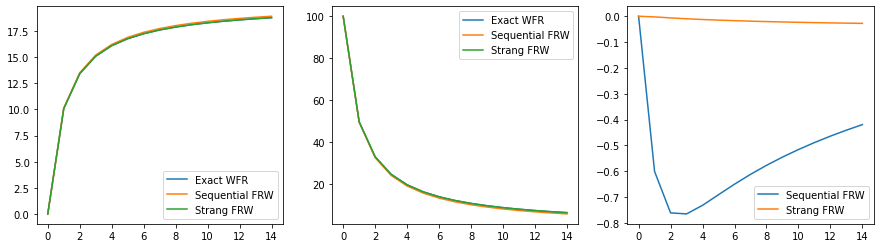

In [8]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_wfr, label = 'Exact WFR')
plt.plot(mean_eq_seq_frw, label = 'Sequential FRW')
plt.plot(mean_eq_strang_frw, label = 'Strang FRW')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(var_eq_wfr, label = 'Exact WFR')
plt.plot(var_eq_seq_frw, label = 'Sequential FRW')
plt.plot(var_eq_strang_frw, label = 'Strang FRW')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(kl_evo_seq_frw - kl_evo_wfr, label = 'Sequential FRW')
plt.plot(kl_evo_strang_frw - kl_evo_wfr, label = 'Strang FRW')
plt.legend()

## Combined (sequential only)

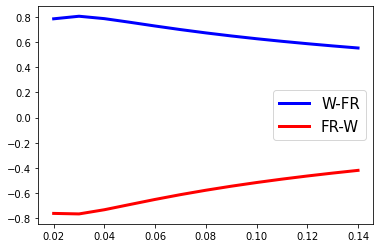

In [9]:
plt.figure(figsize = (6, 4))
plt.plot(gamma*np.arange(discr)[2:], kl_evo_seq_wfr[2:] - kl_evo_wfr[2:], label = 'W-FR', lw = 3, color = 'blue')
plt.plot(gamma*np.arange(discr)[2:], kl_evo_seq_frw[2:] - kl_evo_wfr[2:], label = 'FR-W', lw = 3, color = 'red')
plt.legend(fontsize = 15)
# plt.savefig("kl_sequential_gaussian_concentrated_target.pdf")